# Notebook de identificación de huellas digitales utilizando CNN

In [8]:
import os
import cv2
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
# Información del entorno
print("TensorFlow Version: ", tf.__version__)
print("Eager Mode: ", tf.executing_eagerly())
print("GPU: ", "Available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

#### Funciones utilitarias para socofing

In [27]:
# selección del dataset de socofing (altered-easy, altered-medium, altered-hard)


def mostrar_imagen(imagen, titulo, tamaño=(10, 10)):
    """
    Muestra una imagen con un título y tamaño ajustable.

    Args:
        imagen: Imagen a mostrar.
        titulo: Título que se mostrará en la parte superior.
        tamaño: Tupla (ancho, alto) para ajustar el tamaño de la figura en pulgadas.
    """
    plt.figure(figsize=tamaño)
    plt.imshow(imagen, cmap='gray')
    plt.title(titulo)
    plt.axis('off')  # Para ocultar los ejes
    plt.show()

def load_data(path, train=True, normalize=True):
    print("Loading data from: ", path, ", número de clases ", num_classes)
    images, subject_ids = [], []
    
    for img in os.listdir(path):
        if not img.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png')):
            print(f"Archivo no válido: {img}")
            continue
        if num_classes == 600 and img.lower().startswith('601'):
            #print(f"Archivo omitido: {img}")
            continue
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1  # to_categorical encodes starting from 0
        
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        
        if normalize:
            img_resize = img_resize / 255.0  # Normalizar a [0, 1]
        
        images.append(img_resize)
        subject_ids.append(ID)
    
    return np.array(images), np.array(subject_ids)


def verificar_huellas(model, X_test, y_SubjectID_test, n_pruebas=5):
    """
    Verifica si una huella coincide con el registro, realizando múltiples predicciones.
    
    Args:
        model: El modelo de clasificación entrenado.
        X_test: El conjunto de imágenes de prueba.
        y_SubjectID_test: Las etiquetas correspondientes a las imágenes de prueba.
        n_pruebas: Número de veces que se realizará la predicción. (por defecto 5)
    """
    for _ in range(n_pruebas):
        # Seleccionar una imagen aleatoria del conjunto de prueba
        random_index = random.randint(0, len(X_test) - 1)  # Índice del usuario
        user_image = X_test[random_index].reshape(1, 96, 96, 1)  # Imagen del usuario
        user_true_label = np.argmax(y_SubjectID_test[random_index])  # Etiqueta real

        # Predicción para la imagen del usuario
        user_prediction = model.predict(user_image)
        predicted_label = np.argmax(user_prediction)
        prediction_probability = user_prediction[0][predicted_label]  # Probabilidad de la predicción

        # Verificar si coincide
        is_match = user_true_label == predicted_label

        # Mostrar la imagen con el resultado
        mostrar_imagen(user_image.squeeze(), 
                        f"Etiqueta Real: {user_true_label}, "
                        f"Etiqueta Predicha: {predicted_label}, "
                        f"Probabilidad: {prediction_probability:.4f}, "
                        f"Coincide: {is_match}", 
                        tamaño=(2, 2))



### Construyendo el modelo con el dataset de socofing
- Selección del dataset
- Carga de imágenes en matrices np
- Configurar las matrices de entrenamiento y validación (x_train, x_val, y_train, y_val)
- Configuración de la arquitectura del CNN
- Evaluación del modelo


---
#### Selección del dataset
Se tiene la siguiente estructura de archivos : 

Dataset Url : https://www.kaggle.com/datasets/ruizgara/socofing

```
├── Altered
│   ├── Altered-Easy # imágenes alteradas levemente 
│   ├── Altered-Hard # imágenes alteradas complejamente
│   └── Altered-Medium # imágenes alteradas medianamente
└── Real # imágenes reales

6 directories
```

---
#### Carga de imágenes en matrices np

In [10]:
# DEFINICIONES GLOBALES

img_size = 96 # 96 * 96 resolución original...
num_classes = 600 # 600 clases por defecto # 96 * 96 resolucin original...´


In [11]:
# cargando las imágenes en np arrays
Real_path = "./dataset/Real"
Real_images, Real_subjects = load_data(Real_path, train=False)

Altered_path = "./dataset/Altered/Altered-"
Easy_images, Easy_subjects = load_data(Altered_path + 'Easy', train=True)
Medium_images, Medium_subjects = load_data(Altered_path + 'Medium', train=True)
Hard_images, Hard_subjects = load_data(Altered_path + 'Hard', train=True)

# Concatenar las imágenes y etiquetas
# 'Altered_*' equivalente 'Altered_data' = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)
Altered_images = np.concatenate([Easy_images, Medium_images, Hard_images], axis=0)
Altered_subjects = np.concatenate([Easy_subjects, Medium_subjects, Hard_subjects], axis=0)

# (IMPORTANTE) Convirtiendo de escala de grises (96x96) a RGB (96x96x3)
# Altered_images_train = np.repeat(Altered_images[..., np.newaxis], 3, axis=-1)
# Codificar etiquetas one-hot
Altered_subjects_validation = to_categorical(Altered_subjects, num_classes=num_classes)

print("Altered images shape:", Altered_images.shape)  # (n_samples, 96, 96)
print("Altered subjects shape:", Altered_subjects.shape)  # (n_samples,)

print("Real_images shape:", Real_images.shape)  # (real n_images, 96 px, 96 px)
print("Real_subjects shape:", Real_subjects.shape)  # (real n_subject,)

print(f"\n# Array 0, Subject {Altered_subjects[0]} with finger image {Altered_images[0].shape}")
print(f"\n# Array 0, Altered_subjects_validation (onehot) {Altered_subjects_validation[0].shape} with Altered_images_train {Altered_images[0].shape}")

Loading data from:  ./dataset/Real , número de clases  600
Loading data from:  ./dataset/Altered/Altered-Easy , número de clases  600
Archivo no válido: .DS_Store
Loading data from:  ./dataset/Altered/Altered-Medium , número de clases  600
Archivo no válido: .DS_Store
Loading data from:  ./dataset/Altered/Altered-Hard , número de clases  600
Archivo no válido: .DS_Store
Altered images shape: (49270, 96, 96)
Altered subjects shape: (49270,)
Real_images shape: (6000, 96, 96)
Real_subjects shape: (6000,)

# Array 0, Subject 246 with finger image (96, 96)

# Array 0, Altered_subjects_validation (onehot) (600,) with Altered_images_train (96, 96)


---
#### Configurar las matrices de entrenamiento y validación (x_train, x_val, y_train, y_val)

In [12]:
# 1. Dividir el conjunto de datos en entrenamiento y validación (80% entrenamiento, 20% validación)
X_train, X_val, y_train, y_val = train_test_split(Altered_images, Altered_subjects_validation, test_size=0.2, random_state=42)

# 2. Armando la matriz de comprobación o test.
X_test, y_SubjectID_test = [], []
for i in range(len(Real_images)):  # Todas las estructuras tienen el mismo tamaño (6000)
    X_test.append(Real_images[i])         # Agregar la imagen (96x96)
    y_SubjectID_test.append(Real_subjects[i])  # Agregar el SubjectID correspondiente
    
X_test = np.array(X_test)
y_SubjectID_test = to_categorical(y_SubjectID_test, num_classes=num_classes)

In [13]:
print("Shapes:                  Feature shape    label shape")
print("----------------------------------------------------")
print("full SubjectID data:  ", Altered_images.shape, Altered_subjects_validation.shape)
print("SubjectID_Train:      ", X_train.shape, y_train.shape)
print("SubjectID_Validation: ", X_val.shape, y_val.shape)
print("SubjectID_Test:       ", X_test.shape, y_SubjectID_test.shape)


Shapes:                  Feature shape    label shape
----------------------------------------------------
full SubjectID data:   (49270, 96, 96) (49270, 600)
SubjectID_Train:       (39416, 96, 96) (39416, 600)
SubjectID_Validation:  (9854, 96, 96) (9854, 600)
SubjectID_Test:        (6000, 96, 96) (6000, 600)


---
#### Configuración de la arquitectura del CNN

In [19]:
# Parámetros de configuración
final_Dense_units = num_classes  # Para una sola salida de clases
current_learning_rate = 1e-4
epochs = 20
batch_size = 64

# Crear el modelo
model = Sequential(name='SubjectID_Mod')

model.add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (img_size, img_size, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(64, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(final_Dense_units, activation='softmax'))


# Crear optimizador
opt = optimizers.legacy.Adam(learning_rate=current_learning_rate)

# Compilar el modelo
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# Resumen del modelo
model.summary()

Model: "SubjectID_Mod"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 92, 92, 32)        832       
                                                                 
 batch_normalization_3 (Bat  (None, 92, 92, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 batch_normalization_4 (Bat  (None, 42, 42, 64)        256       
 chNormalization)                                                
                                                     

In [20]:
ReduceLR_minlr = current_learning_rate

CallBack = [
    callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
    callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr, verbose=1),
    callbacks.TensorBoard(log_dir="./log_dir/SubjectID_Mod")]

history = model.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_val, y_val),
                    verbose = 1, callbacks= CallBack)

Epoch 1/20


2024-12-18 16:05:16.484076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-18 16:05:16.505729: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2024-12-18 16:05:16.515395: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


616/616 [==============================] - ETA: 0s - loss: 6.5030 - accuracy: 0.0042

2024-12-18 16:05:42.237556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-18 16:05:42.246032: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2024-12-18 16:05:42.250018: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


616/616 [==============================] - 29s 38ms/step - loss: 6.5030 - accuracy: 0.0042 - val_loss: 6.3298 - val_accuracy: 0.0067 - lr: 1.0000e-04
Epoch 2/20
616/616 [==============================] - 20s 33ms/step - loss: 5.9957 - accuracy: 0.0263 - val_loss: 5.3856 - val_accuracy: 0.0950 - lr: 1.0000e-04
Epoch 3/20
616/616 [==============================] - 20s 33ms/step - loss: 4.6645 - accuracy: 0.1486 - val_loss: 3.6057 - val_accuracy: 0.4066 - lr: 1.0000e-04
Epoch 4/20
616/616 [==============================] - 20s 33ms/step - loss: 2.8805 - accuracy: 0.4176 - val_loss: 1.7817 - val_accuracy: 0.7501 - lr: 1.0000e-04
Epoch 5/20
616/616 [==============================] - 20s 33ms/step - loss: 1.5900 - accuracy: 0.6670 - val_loss: 0.9463 - val_accuracy: 0.8941 - lr: 1.0000e-04
Epoch 6/20
616/616 [==============================] - 20s 33ms/step - loss: 0.9108 - accuracy: 0.8191 - val_loss: 0.5318 - val_accuracy: 0.9475 - lr: 1.0000e-04
Epoch 7/20
616/616 [=========================

In [30]:
# Guardar el modelo completo (arquitectura + pesos + optimizador)
model.save('./assets/subject_id_model_600_classes.h5')
# Alternativamente, guardar en formato TensorFlow (recomendado para TensorFlow 2.x)
model.save('./assets/subject_id_model_600_classes')

# model = load_model('./assets/subject_id_model_600_classes.h5')


/Users/kenny/Programs/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: ./assets/subject_id_model_600_classes/assets


INFO:tensorflow:Assets written to: ./assets/subject_id_model_600_classes/assets



---
```
total 301328
drwxr-xr-x@ 7 kenny  staff       224 18 dic 16:36 subject_id_model_600_classes
-rw-r--r--@ 1 kenny  staff  35306136 18 dic 16:36 subject_id_model_600_classes.h5
```
---

### Finetunning a modelos preentrenados para el reconocimiento de huellas
- Selección del dataset
- Preprocesar las imágenes (gray -> rgb)
- Definir el imagedatagenerator y cargarlo con las imágenes rgb
- Definir el modelo preentrenado (resnet50, vgg16)
- Configurar el modelo preentrenado para el ajuste fino (freeze layers, fit, unfreeze some layers, fit)
- Evaluación del modelo

---
### Evaluando el modelo en base a sus predicciones e historico de entrenamiento
- Historico de entrenamiento
- Predicción contra una huella del dataset Test
- Predicción contra una lista de huellas del dataset Test


---
#### Historico de entrenamiento

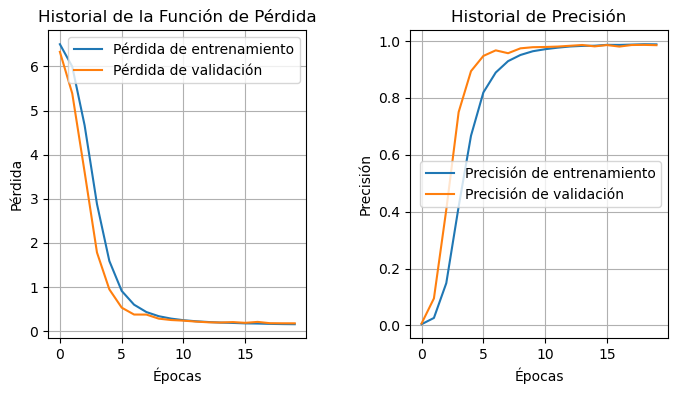

In [23]:
import matplotlib.pyplot as plt

# Graficar ambos cuadros horizontalmente en un solo layout
plt.figure(figsize=(12, 6))

# Graficar la función de pérdida
plt.subplot(1, 2, 1)  # (filas, columnas, índice del gráfico)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Historial de la Función de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Graficar la precisión
plt.subplot(1, 2, 2)  # (filas, columnas, índice del gráfico)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Historial de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Ajustar el tamaño de la figura y mostrarla
plt.subplots_adjust(wspace=0.4)
plt.gcf().set_size_inches(8, 4)  # Tamaño ajustado de los gráficos (aproximadamente 300px o 400px)
plt.show()


---
#### Predicción contra una huella del dataset Test

1/1 [==============================] - 0s 15ms/step


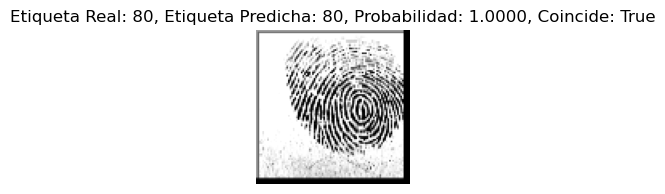

In [28]:
verificar_huellas(model, X_test, y_SubjectID_test, n_pruebas=1)


---
#### Predicción contra una lista de huellas del dataset Test

1/1 [==============================] - 0s 13ms/step


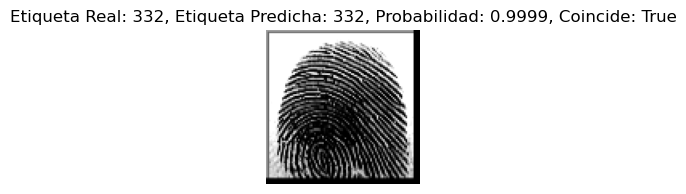

1/1 [==============================] - 0s 13ms/step


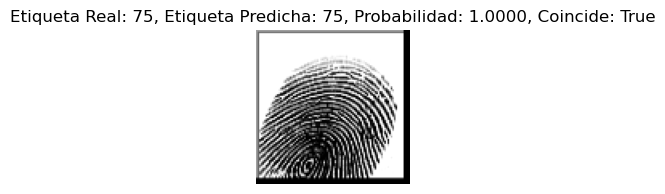

1/1 [==============================] - 0s 11ms/step


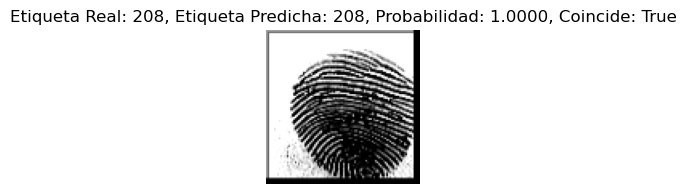

1/1 [==============================] - 0s 11ms/step


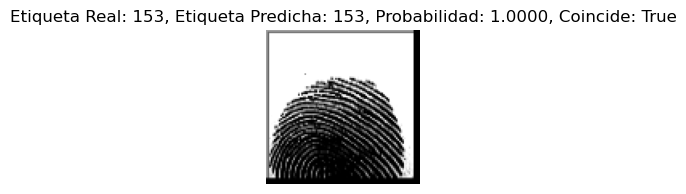

1/1 [==============================] - 0s 12ms/step


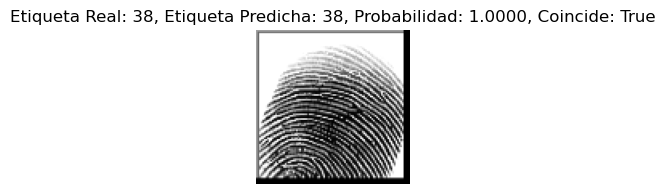

1/1 [==============================] - 0s 10ms/step


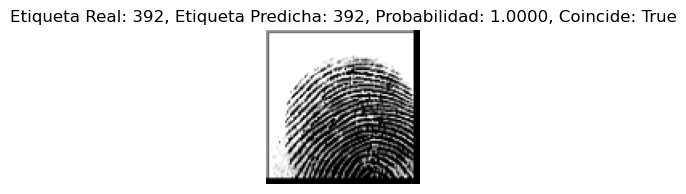

1/1 [==============================] - 0s 10ms/step


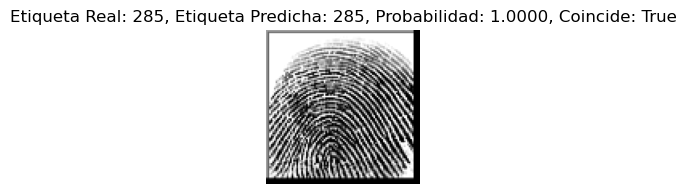

1/1 [==============================] - 0s 12ms/step


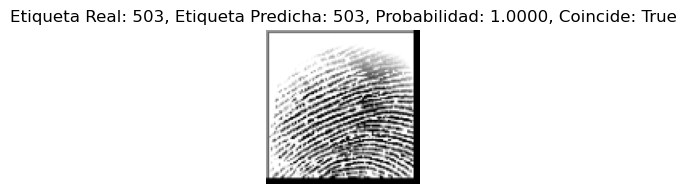

1/1 [==============================] - 0s 11ms/step


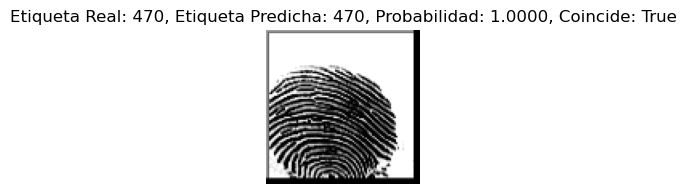

1/1 [==============================] - 0s 11ms/step


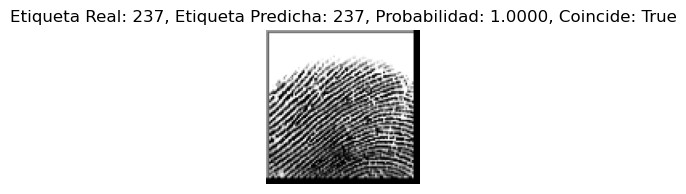

In [31]:
verificar_huellas(model, X_test, y_SubjectID_test, n_pruebas=10)


---
#### Predicción contra una huella no registrada

1/1 [==============================] - 0s 16ms/step


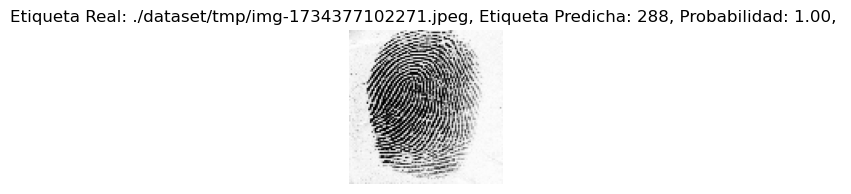

In [33]:

target_image_path = "./dataset/tmp/img-1734377102271.jpeg"
#target_image_path = "./dataset/Real/1011__M_Right_index-Dennis_20241213102716.jpeg"

target_image = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)
target_image = cv2.resize(target_image, (img_size, img_size)) # img_size = 96


target_image_reshaped = target_image.reshape(1, img_size, img_size, 1)  # Dimensiones: (1, img_size, img_size, 1)
prediction = model.predict(target_image_reshaped)
predicted_label = np.argmax(prediction)
prediction_probability = prediction[0][predicted_label]  # Probabilidad de la predicción

# Mostrar la imagen con el resultado
mostrar_imagen(target_image.squeeze(), 
                f"Etiqueta Real: {target_image_path}, "
                f"Etiqueta Predicha: {predicted_label}, "
                f"Probabilidad: {prediction_probability:.2f}, ", 
                tamaño=(2, 2))


### Conclusiones
- El modelo tiene una precisión buena para las imágenes entrenadas, sin embargo, se sugiere aplicar los siguientes ajustes para poder cubrir más escenarios donde aún le falta mejorar :
  - Aplicar Aumento de Datos con ImageDataGenerator para poder generar mayor variabilidad en las imágenes (horizontal/vertical flip).
  - Aplicar transfer learning con modelos preentrenados como VGG16 y/o ResNet50 , hay artículos q comentan haber encontrado grandes mejoras.
    - Link de los artículos :
      - "Fingerprint recognition using convolution neural network with inversion and augmented techniques" https://www.sciencedirect.com/science/article/pii/S2772941924000358#sec0003
      - "FINGERPRINT CLASSIFICATION USING DEEP NEURAL NETWORK MODEL RESNET50" https://ijrar.org/papers/IJRAR1944186.pdf
      - "Fingerprint-Classification-with-ResNet50" https://github.com/MohibAyub/Fingerprint-Classification-with-ResNet50/tree/main